# Caffe Results

## Initial setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 18.0}
plt.rc('font', **font)  # pass in the font dict as kwargs


%load_ext autoreload
%autoreload 2

## From scratch

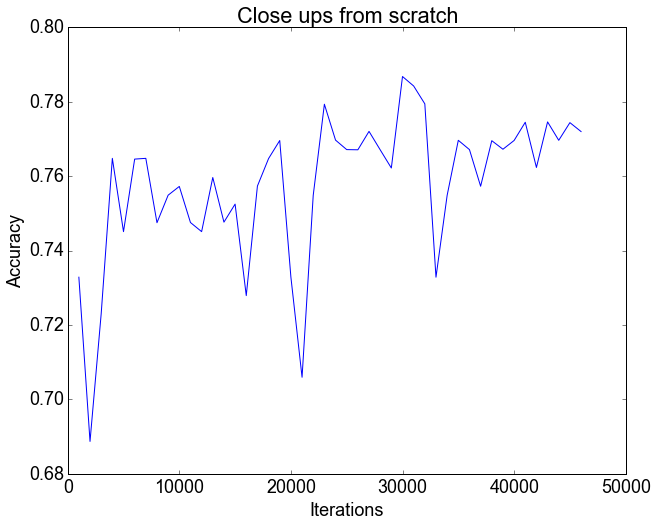

In [4]:
scratch_near = 'accuracies.csv'
fp_scratch_near = open(scratch_near, 'r')

x = []
y = []

for line in fp_scratch_near:
    xi, yi = line.strip().split(',')
    x.append(xi)
    y.append(yi)

plt.plot(x, y)
plt.title('Close ups from scratch')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()


### Define feature extraction functions

In [ ]:
def extract_all_gist_features(X):
    num_examples = X.shape[0]
    features = []
    for index in range(num_examples):
        feature_vec = gist.extract(X[index].astype('uint8'))
        features.append(feature_vec)
    
    X_features = np.vstack(features)
    return X_features

In [ ]:
def extract_gist(I):
    return gist.extract(I.astype('uint8'))

In [ ]:
def tiny_image(image_array, width=16, height=16):
    I = Image.fromarray(image_array.astype('uint8'))
    I_tiny = I.resize((width, height))
    I_tiny_array = np.array(I_tiny).astype('float')
    return np.reshape(I_tiny_array, width * height * 3)

In [ ]:
def color_histogram_rgb(image_array):
    h, edges = np.histogramdd(image_array.reshape(-1,3), 8, normed=True, range=[(0,255), (0,255), (0,255)])
    return h.flatten()

In [ ]:
color_histogram_rgb(X_train[0]).shape

In [ ]:
def extract_features(X, feature_functions):
    num_examples = X.shape[0]
    feature_rows = []
    for index in range(num_examples):
        I = X[index]
        features = []
        for feature_func in feature_functions:
            feature_vec = feature_func(I)
            features.append(feature_vec)
        
        example_features_row_vec = np.hstack(features)
        feature_rows.append(example_features_row_vec)
    
    X_features = np.vstack(feature_rows)
    return X_features

### Extract features and concatenates them

In [ ]:
from features import hog_feature, color_histogram_hsv

num_color_bins = 100 # Number of bins in the color histogram
#feature_fns = [extract_gist, hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist]
#feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, tiny_image]
feature_fns = [extract_gist, tiny_image, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_features = extract_features(X_train, feature_fns)
X_test_features = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_features = np.mean(X_train_features, axis=0)
mean_features = np.expand_dims(mean_features, axis=0)
X_train_features -= mean_features
X_test_features -= mean_features

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_features = np.std(X_train_features, axis=0)
std_features = np.expand_dims(std_features, axis=0)
X_train_features /= std_features
X_test_features /= std_features

# Preprocessing: Add a bias dimension
X_train_features = np.hstack([X_train_features, np.ones((X_train_features.shape[0], 1))])
X_test_features = np.hstack([X_test_features, np.ones((X_test_features.shape[0], 1))])

print(X_train_features.shape)

## Training models
### Naïve Bayes
There are no variables to cross validate here

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train_features, y_train).predict(X_test_features)
print('Naive Bayes accuracy on full training set: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

gnb_cv_accuracies = cross_val_score(gnb, X_train_features, y_train, cv=cv, n_jobs=7)
print('Average Naive Bayes accuracy: %f' % gnb_cv_accuracies.mean())

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_split=16)
y_pred = dtc.fit(X_train_features, y_train).predict(X_test_features)
print('Decision Tree accuracy: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

from sklearn.tree import DecisionTreeClassifier

test_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

dtc_avg_accuracies = []
for v in test_values:
    dtc = DecisionTreeClassifier(min_samples_split=v)
    dtc_cv_accuracies = cross_val_score(dtc, X_train_features, y_train, cv=cv, n_jobs=-1)
    dtc_cv_acc_mean = dtc_cv_accuracies.mean()
    dtc_avg_accuracies.append(dtc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(dtc_cv_acc_mean)
    

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_values, dtc_avg_accuracies)
plt.title('Decision Tree Classifier Cross validation')
plt.ylabel('Average accuracy')
plt.xlabel('Minimum number of samples before splitting')
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1024, min_samples_split=2, n_jobs=-1)
y_pred = rfc.fit(X_train_features, y_train).predict(X_test_features)
print('Random Forest accuracy: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

rfc_avg_accuracies = []
for v in test_values:
    rfc = RandomForestClassifier(n_estimators=v, min_samples_split=2, n_jobs=-1)
    rfc_cv_accuracies = cross_val_score(rfc, X_train_features, y_train, cv=cv, n_jobs=-1)
    rfc_cv_acc_mean = rfc_cv_accuracies.mean()
    rfc_avg_accuracies.append(rfc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(rfc_cv_acc_mean)
    

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_values, rfc_avg_accuracies)
plt.title('Random Forest Classifier Crossvalidation')
plt.ylabel('Average accuracy')
plt.xlabel('Number of Estimators')
plt.show()

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

rfc_avg_accuracies = []
for v in test_values:
    rfc = RandomForestClassifier(n_estimators=128, min_samples_split=v, n_jobs=-1)
    rfc_cv_accuracies = cross_val_score(rfc, X_train_features, y_train, cv=cv, n_jobs=-1)
    rfc_cv_acc_mean = rfc_cv_accuracies.mean()
    rfc_avg_accuracies.append(rfc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(rfc_cv_acc_mean)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_values, rfc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.xlabel('Minimum number of samples before splitting')
plt.title('Random Forest Classifier Crossvalidation')
plt.show()

### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.01, n_estimators=128, max_features='auto')
y_pred = gbc.fit(X_train_features, y_train).predict(X_test_features)
print('Gradient Boosting accuracy: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

n_values = [32, 64, 128, 256, 512]
rate_values = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

gbc_avg_accuracies = []
for n in n_values:
    n_avgs = []
    for r in rate_values:
        gbc = GradientBoostingClassifier(learning_rate=r, n_estimators=n, max_features='auto')
        gbc_cv_accuracies = cross_val_score(gbc, X_train_features, y_train, cv=cv, n_jobs=-1)
        gbc_cv_acc_mean = gbc_cv_accuracies.mean()
        n_avgs.append(gbc_cv_acc_mean)
        print 'Average accuracy with ' + str(n) + ', ' + str(r) + ' : ' + str(gbc_cv_acc_mean)
    gbc_avg_accuracies.append(n_avgs)

In [ ]:
import matplotlib.pyplot as plt

for i, n in enumerate(gbc_avg_accuracies):
    plt.plot(rate_values, n, label=str(i))

plt.legend()
plt.ylabel('Average accuracy')
plt.show()

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(min_samples_split=16)

abc = AdaBoostClassifier(algorithm='SAMME', base_estimator=dtc, n_estimators=40, learning_rate=1.0)
y_pred = abc.fit(X_train_features, y_train).predict(X_test_features)
print('Ada Boosting accuracy: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

# imports for calling the base classfifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

bases = {
    'stump' : DecisionTreeClassifier(max_depth=2),
    'dtc' : DecisionTreeClassifier(min_samples_split=16, max_features='auto'),
    'svm' : SVC(kernel='linear', class_weight='auto')
}

n_estimators_values = [2, 4, 8, 16, 32, 64]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=5, shuffle=True, random_state=None)

gbc_avg_accuracies = []
for bs, bo in bases.items():
    n_avgs = []
    for n in n_estimators_values:
        gbc = AdaBoostClassifier(algorithm='SAMME', base_estimator=bo, n_estimators=n, learning_rate=1.0)
        gbc_cv_accuracies = cross_val_score(gbc, X_train_features, y_train, cv=cv, n_jobs=-1)
        gbc_cv_acc_mean = gbc_cv_accuracies.mean()
        n_avgs.append(gbc_cv_acc_mean)
        print 'Average accuracy for ' + bs + ', with ' + str(n) + ' : ' + str(gbc_cv_acc_mean)
    gbc_avg_accuracies.append(n_avgs)

In [ ]:
import matplotlib.pyplot as plt

base_strs = bases.keys()

for i, n in enumerate(gbc_avg_accuracies):
    plt.plot(n_estimators_values, n, label=base_strs[i])

plt.legend()
plt.ylabel('Average accuracy')
plt.show()

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='auto')
svm.fit(X_train_features, y_train)

y_pred = svm.predict(X_test_features)
print('SVM accuracy: %f' % (np.mean(y_pred == y_test)))

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

svm_cv_accuracies = cross_val_score(svm, X_train_features, y_train, cv=cv, n_jobs=7)
print(svm_cv_accuracies)